
#A1:RESEARCH QUESTION

The research question I will address is: "Can we predict future daily revenue for the organization based on historical data?" This question is highly relevant to the organization as accurate daily revenue predictions can significantly improve the company’s financial planning and forecasting capabilities.

Future daily revenue refers to the predicted revenue for each day in the forecast horizon. Accurate daily revenue forecasts allow the organization to track and manage cash flow on a day-to-day basis, enabling more precise operational planning. This includes anticipating fluctuations in revenue due to trends or seasonality and responding to those changes in real-time. By developing a time series model, we can predict future daily revenue using historical revenue patterns. This model will provide actionable insights that can be used to:

- Inform revenue projections, helping the company set realistic financial goals.

- Guide headcount adjustments, ensuring staffing aligns with revenue expectations.

- Identify optimal times for marketing promotions and resource allocation, maximizing revenue during peak periods and minimizing operational costs during slower periods.

A well-constructed time series model will enable the executive leadership team to make data-driven decisions, improving the telecom company’s competitiveness and operational efficiency.


#A2:OBJECTIVES OR GOALS

The objectives of this data analysis are as follows:
1. Utilize historical revenue data to create an accurate time series model capable of forecasting future daily revenue trends for the organization.
2. Analyze the historical revenue data to identify any underlying trends, seasonality, or patterns that could provide insights into how revenue changes over time.
3. Use the forecasts generated by the model to support the organization in making informed strategic decisions, such as workforce planning, budgeting, and promotional initiatives.


These objectives are feasible within the scope of the dataset, as they focus on predicting daily revenue, analyzing historical patterns, and applying the insights for business planning purposes.



#B:SUMMARY OF ASSUMPTIONS

A time series model relies on several key assumptions to effectively analyze and predict data over time. These include:
1. Stationarity: A fundamental assumption is that the time series is stationary, meaning its statistical properties (e.g., mean, variance, and autocovariance) remain constant over time. Stationarity is crucial for model stability and ensures that relationships identified in the past can be generalized for forecasting. If a time series is non-stationary, transformations like differencing or logarithmic scaling are often used to achieve stationarity.
2. Autocorrelation: Time series models assume that observations are not independent, meaning there is a correlation between past and future values. This autocorrelation allows the model to use past values to predict future ones. Identifying significant autocorrelations helps in selecting appropriate lags and building effective models, such as ARIMA (Auto-Regressive Integrated Moving Average).
3. Linearity and Lag Dependence: Many time series models assume a linear relationship between past values and future predictions. These relationships are often captured in terms of lags, where the value at a given time is dependent on previous values (lags) in a linear manner.

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/D213')

In [ ]:
! pip install pmdarima
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.gridspec as gridspec
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

#parse_dates is used to remove interference during analysis
df = pd.read_csv('/content/drive/MyDrive/D213/teleco_time_series.csv', index_col='Day', parse_dates=True)
print(df.head(5))
print(df.tail(5))

      Revenue
Day          
1    0.000000
2    0.000793
3    0.825542
4    0.320332
5    1.082554
       Revenue
Day           
727  16.931559
728  17.490666
729  16.803638
730  16.194813
731  16.620798


In [ ]:
#adjusting the date column to yyyy-mm-dd
df.index = pd.date_range(start='2021-01-01', periods=len(df), freq='D')

#C1:LINE GRAPH VISUALIZATION

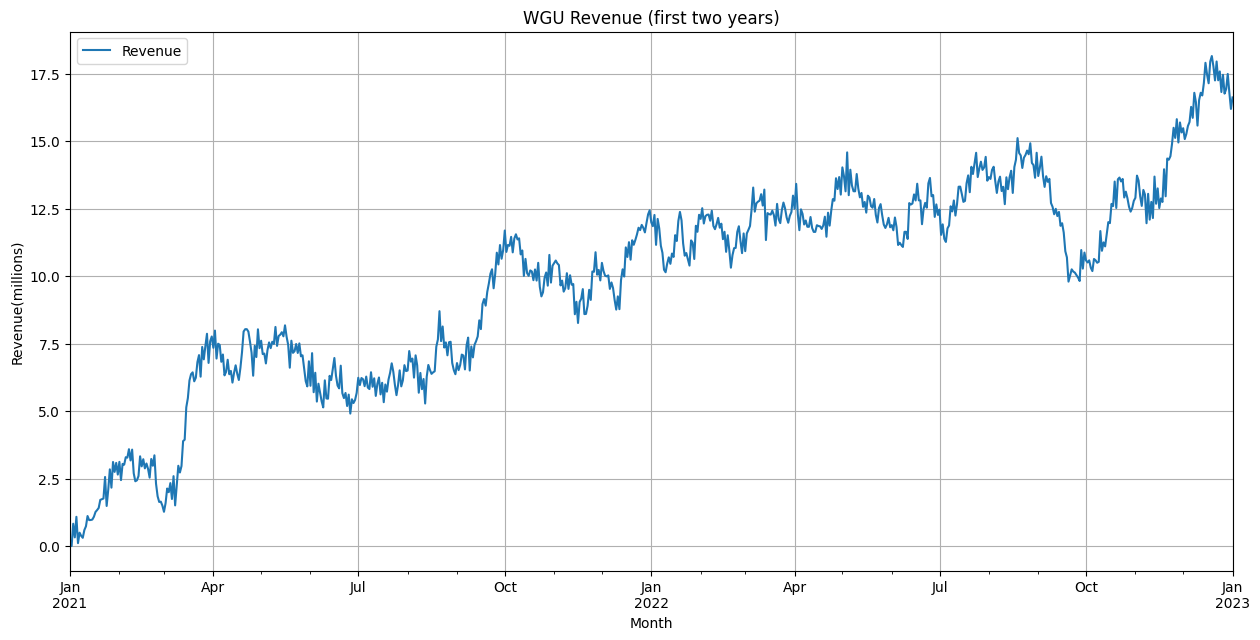

In [ ]:
#plotting line graph
df.plot(grid=True, figsize=(15, 7))
plt.title('WGU Revenue (first two years)')
plt.xlabel('Month')
plt.ylabel('Revenue(millions)')
plt.show()


#C2:TIME STEP FORMATTING

The time step formatting of the realization in this dataset is based on daily observations, with each time step representing a single day. The dataset includes a continuous time series without any gaps in measurement, meaning that every day from the start to the end of the sequence is represented.
- Length of the Sequence: The dataset spans 731 days, covering a period from January 1, 2021, to January 1, 2023.
- Gaps in Measurement: There are no missing dates or observations, as confirmed by inspecting the datetime index of the dataset.

This ensures the consistency and reliability of the time series for further modeling, with no need for interpolation or gap-filling techniques.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2021-01-01 to 2023-01-01
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [ ]:
df.describe()

,Revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


In [ ]:
df.duplicated().sum()

0


#C3:STATIONARITY

To evaluate the stationarity of the time series, I performed the Augmented Dickey-Fuller (ADF) test and analyzed the visual patterns of the series. The ADF test is a statistical test used to determine whether a time series is stationary. The null hypothesis of the ADF test is that the time series is non-stationary.
- ADF Statistic: -1.924612
- p-value: 0.320573
- Critical Values:
 - 1%: -3.439
 - 5%: -2.866
 - 10%: -2.569

Since the p-value (0.320573) is greater than the significance levels (1%, 5%, and 10%), we fail to reject the null hypothesis, indicating that the time series is non-stationary in its original form.

The revenue time series plot shows increasing trends and patterns, suggesting the presence of non-stationarity. The mean and variance appear to change over time, reinforcing that the series is non-stationary. To address the non-stationarity, I applied first-order differencing. After differencing, the ADF test was conducted again:
- ADF Statistic (Differenced Series): -44.874527
- p-value: 0.000000

After differencing, the p-value is less than 0.05, which means the differenced series is stationary. This shows that the series becomes stationary after differencing, allowing us to proceed with time series modeling.


In [ ]:
#performing adf test
series = df['Revenue']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.924612
p-value: 0.320573
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


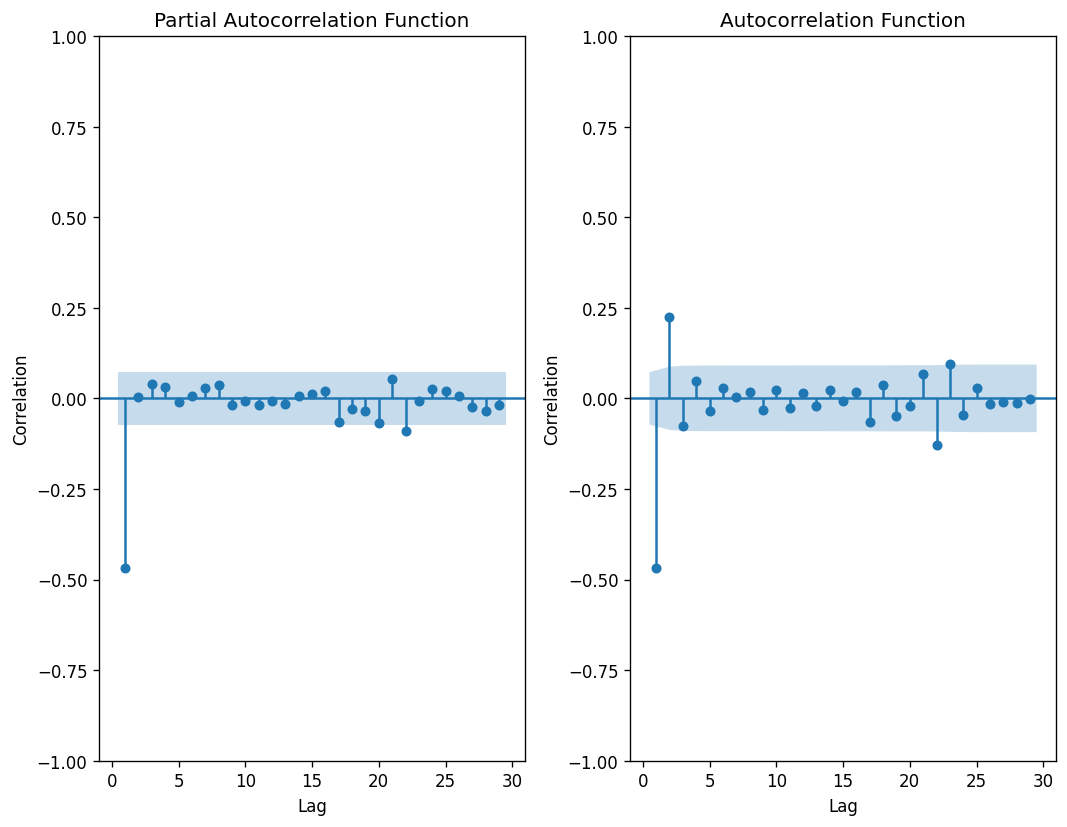

In [ ]:
#PACF plot for autoregressive terms
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

plot_pacf(df['Revenue'].diff().dropna(), ax=axes[0], zero=False)
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')
axes[0].set_title('Partial Autocorrelation Function')

plot_acf(df['Revenue'].diff().dropna(), ax=axes[1], zero=False)
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Correlation')
axes[1].set_title('Autocorrelation Function')

plt.tight_layout()
plt.show()

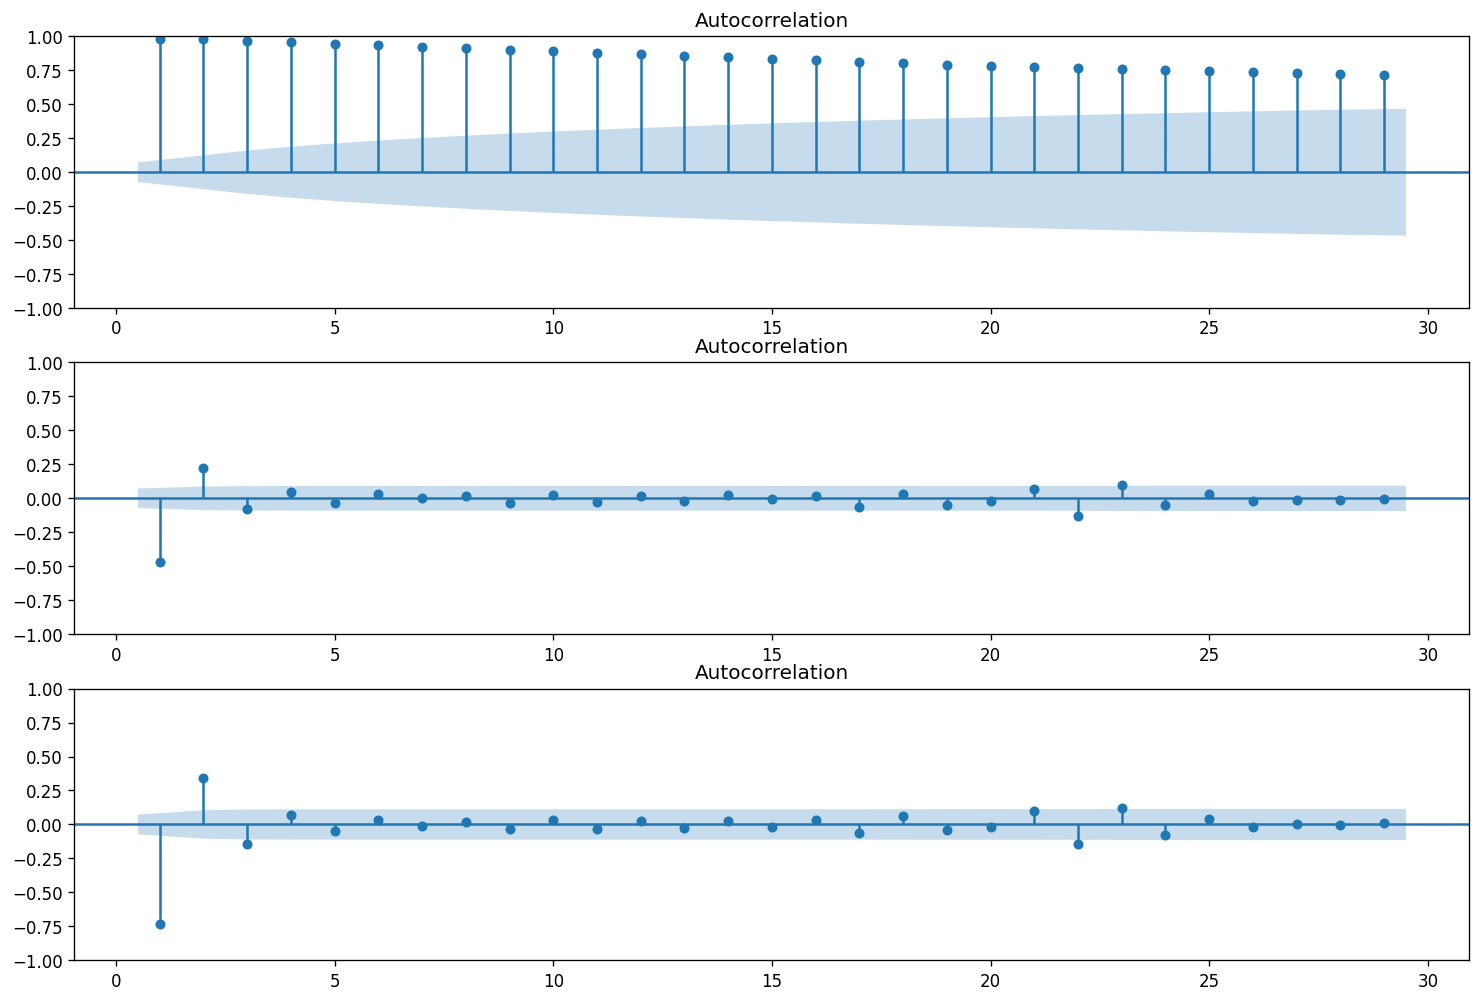

In [ ]:
#Plot acf
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

plot_acf(df['Revenue'], ax=ax1, zero=False)
plot_acf(df['Revenue'].diff().dropna(), ax=ax2, zero=False)
plot_acf(df['Revenue'].diff().diff().dropna(), ax=ax3, zero=False)
plt.show()

In [ ]:
#autoregressive description
model = ARIMA(df['Revenue'], order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -490.355
Date:                Sun, 13 Oct 2024   AIC                            984.710
Time:                        04:30:44   BIC                            993.896
Sample:                    01-01-2021   HQIC                           988.254
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4667      0.033    -14.213      0.000      -0.531      -0.402
sigma2         0.2243      0.013     17.782      0.000       0.200       0.249
Ljung-Box (L1) (Q):                   0.00   Jarque-

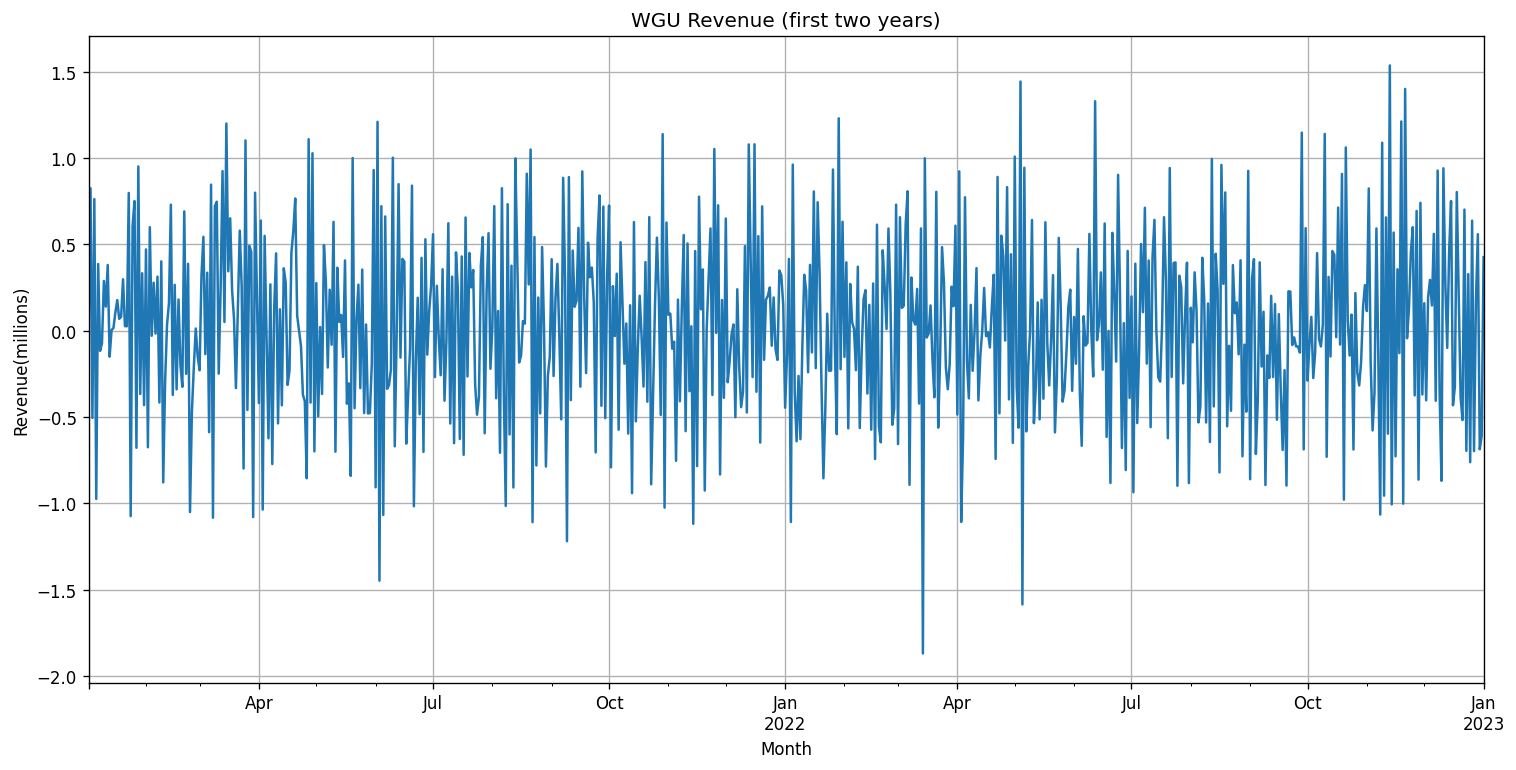

In [ ]:
#First difference of time series
df['Revenue'].diff().dropna().plot(grid=True, figsize=(15, 7))
plt.title('WGU Revenue (first two years)')
plt.xlabel('Month')
plt.ylabel('Revenue(millions)')
plt.show()

In [ ]:
#ADF test
result = adfuller(df['Revenue'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -44.874527
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


In [ ]:
#Split data into training and testing
train, test = train_test_split(df, test_size=0.2, shuffle=False)
print(train.shape)
print(test.shape)

(584, 1)
(147, 1)



#C4:STEPS TO PREPARE THE DATA

The following steps were taken to prepare the data for time series analysis:
###1. Loading the Dataset:
The dataset was loaded using pandas, with the Day column parsed as a datetime index to ensure correct time series handling.

**Command**:

pd.read_csv('teleco_time_series.csv', index_col='Day', parse_dates=True)
2. Adjusting the Date Format:
To ensure that the dates were properly formatted, the datetime index was adjusted to have a continuous sequence from the starting point of January 1, 2021, using:

**Command**:

df.index = pd.date_range(start='2021-01-01', periods=len(df), freq='D')
###3. Handling Missing Data:
I checked for missing or duplicated values in the dataset using *.duplicated().sum()* and *.isnull().sum()* methods, confirming that there were no missing or duplicated values.

###4. Descriptive Statistics:
Descriptive statistics were generated using *df.describe()* to better understand the spread and behavior of the revenue data, including mean, standard deviation, and quantiles.

###5. Stationarity Check and Differencing:
An Augmented Dickey-Fuller (ADF) test was performed to evaluate stationarity. Since the original time series was found to be non-stationary (p-value > 0.05), I applied first-order differencing to remove trends and achieve stationarity.
The differencing was done using: df['Revenue'].diff().dropna()
After differencing, the ADF test was repeated, confirming that the series was stationary.

###6. Data Visualization:
The time series was plotted using matplotlib to visualize trends and seasonality.
Additionally, ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots were generated to assess the autocorrelations and partial autocorrelations in the data.
Seasonal decomposition was also performed to break down the series into trend, seasonal, and residual components using *seasonal_decompose()*.

###7. Splitting the Data into Training and Test Sets:
The data was split into training and test sets using an 80-20 ratio. The first 80% of the data was used for training, and the remaining 20% for testing.
This was done using the *train_test_split()* function from sklearn with shuffle=False to preserve the time series order.
The sizes of the training and test sets were confirmed:
 - Training Set: 584 observations
 - Test Set: 147 observations

###8. Saving the Split Data:
Both the training and test sets were saved as separate CSV files for easy access during model training and evaluation.


In [ ]:
#train & test sets to csv
train.to_csv('train.csv')
test.to_csv('test.csv')


#D1:REPORT FINDINGS AND VISUALIZATIONS

###1. Seasonal Component:
- **Presence of Seasonality**: Based on the seasonal decomposition plot, there is a clear and regular seasonal pattern in the data. The seasonality component shows periodic fluctuations at consistent intervals, indicating the presence of a seasonal pattern in the daily revenue.
- **Visualization**: The seasonal component from the decomposition plot shows repetitive cycles, confirming the presence of seasonality in the time series.

###2. Trends:
- **Presence of Trends**: The original revenue time series shows a positive trend, indicating that the revenue is generally increasing over time, with some fluctuations and dips.
- **Visualization**: The trend component in the decomposed time series plot shows an upward trajectory with some periods of stagnation and slight decline, followed by further growth.

###3. Autocorrelation Function (ACF):
- **Findings**: The ACF plot shows strong autocorrelations at the first few lags, indicating that past values are highly correlated with future values. There is a gradual decrease in autocorrelation values as lag increases, suggesting that revenue at a certain day is strongly influenced by its past values.
- **Visualization**: The ACF plot shows significant spikes at the initial lags, which is typical for time series data that have both trend and seasonal components.

###4. Spectral Density:
- **Findings**: The spectral density plot shows peaks at certain frequencies, which indicates the presence of cyclic behavior or periodicity in the time series. The strong peak at low frequencies further supports the idea of trend and seasonality.
- **Visualization**: The spectral density plot highlights the dominant periodic components in the data, with a clear indication of low-frequency components associated with long-term trends.

###5. Decomposed Time Series:
- **Findings**: The decomposed time series shows the original revenue data broken down into three components:
 1. **Trend**: An upward-moving line with some fluctuations.
 2. **Seasonal**: A repeating pattern with a consistent interval.
 3. **Residuals**: The remaining noise after the trend and seasonality have been removed.
- **Visualization**: The decomposition plot presents each component (trend, seasonal, and residual) clearly, making it easy to observe how each part contributes to the overall time series.

###6. Residuals Analysis:
- **Findings**: The residuals from the decomposed series show no clear pattern, indicating that after removing the trend and seasonality, the remaining noise is random. This confirms that the time series is well modeled by the decomposition, and there is no significant remaining trend or structure in the residuals.
- **Visualization**: The residuals plot from the decomposition shows data points scattered around zero, without any clear direction or correlation, which is a sign of a good model.

##Visual Summary:

###1. Time Series Plot:
 - Shows a positive trend with periodic fluctuations.

###2. Autocorrelation Function (ACF) Plot:
 - Displays significant autocorrelations at early lags, confirming that past values are predictive of future values.

###3. Spectral Density Plot:
 - Highlights the dominant low-frequency components, indicating cyclic behavior and trends.

###4. Decomposed Time Series Plot:
 - Breaks down the series into trend, seasonality, and residuals, confirming the presence of clear seasonal patterns and a strong upward trend.

###5. Residuals Plot:
 - Shows that the residuals are random and without trends, confirming that the trend and seasonality have been successfully removed from the data.

These visualizations confirm the presence of both trend and seasonality in the time series, and the residual analysis suggests that the model effectively captures the data's structure.


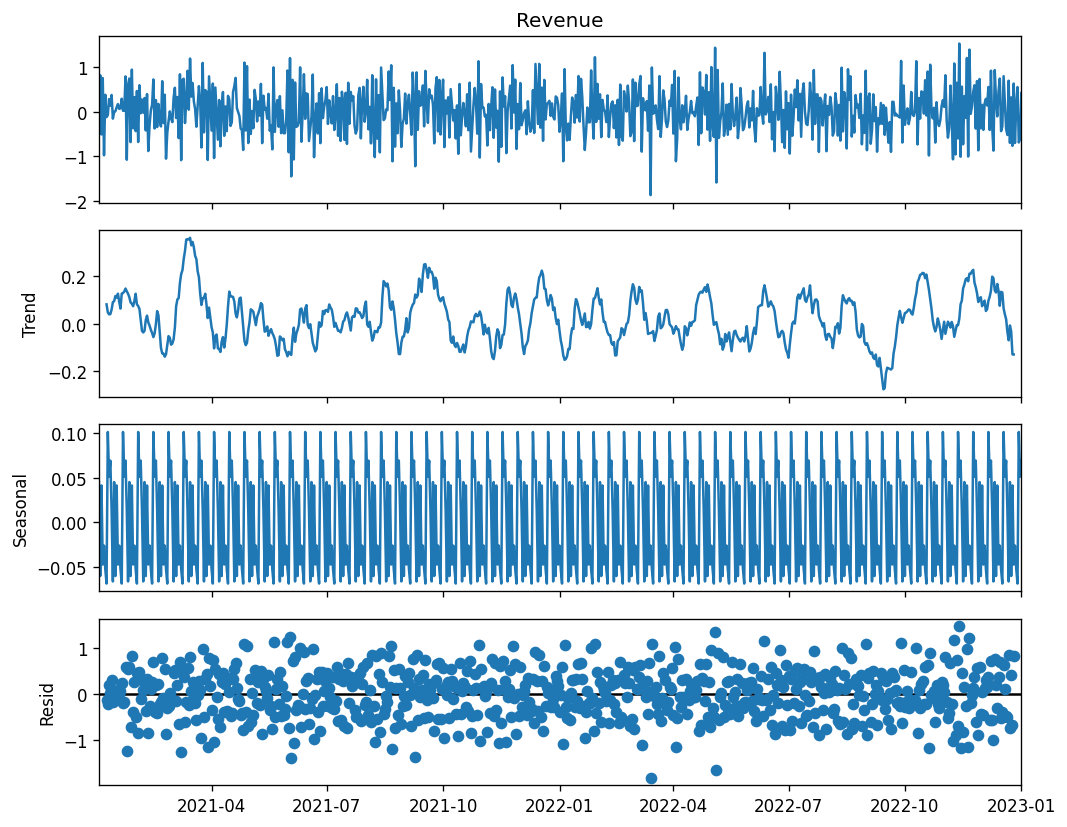

In [ ]:
result = seasonal_decompose(df['Revenue'].diff().dropna(), model='additive', period=12)
#Plot trend, seasonality, residuals
result.plot()
plt.show()

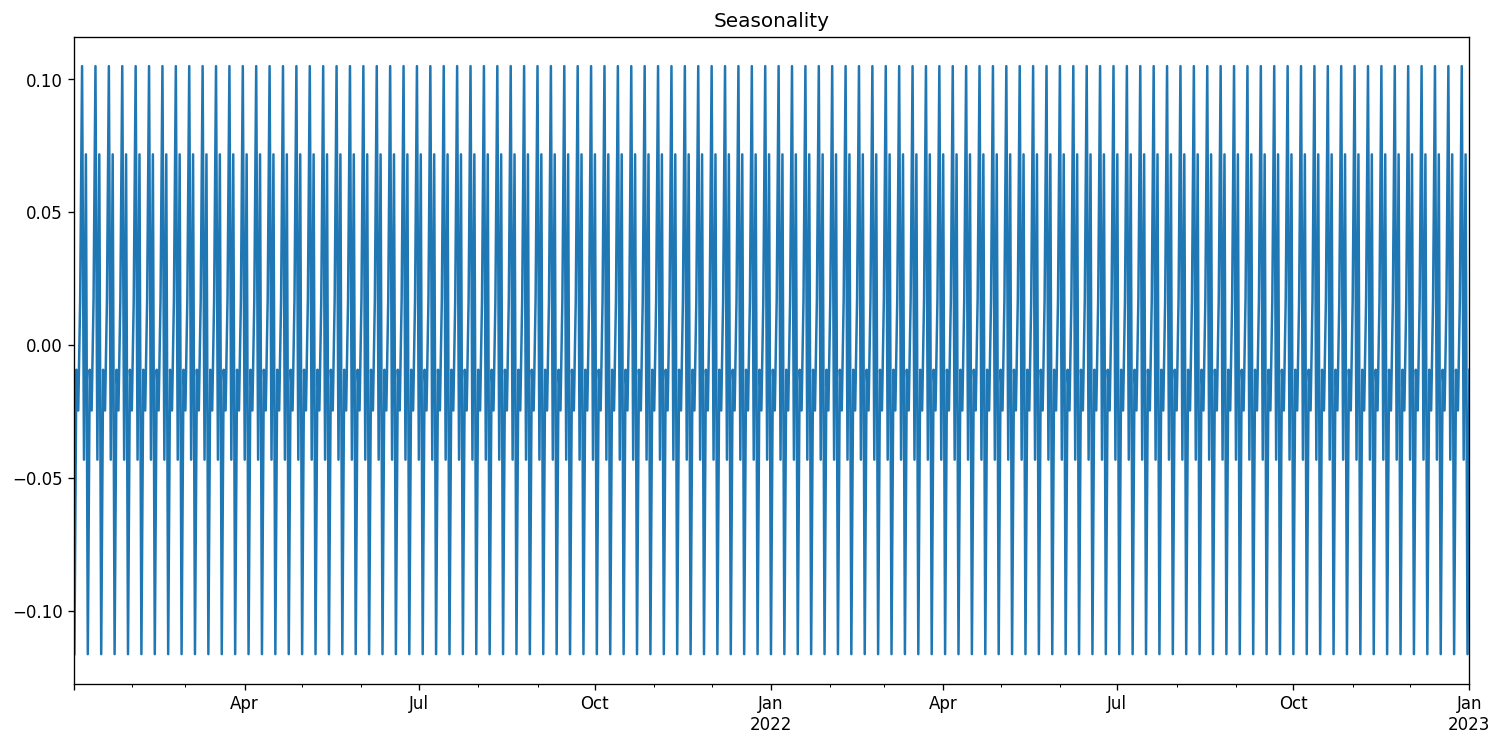

In [ ]:
#Decomposing
decompose_result = seasonal_decompose(df['Revenue'].diff().dropna())
plt.figure(figsize=(15, 7))
plt.title('Seasonality')
plt.show(decompose_result.seasonal.plot())

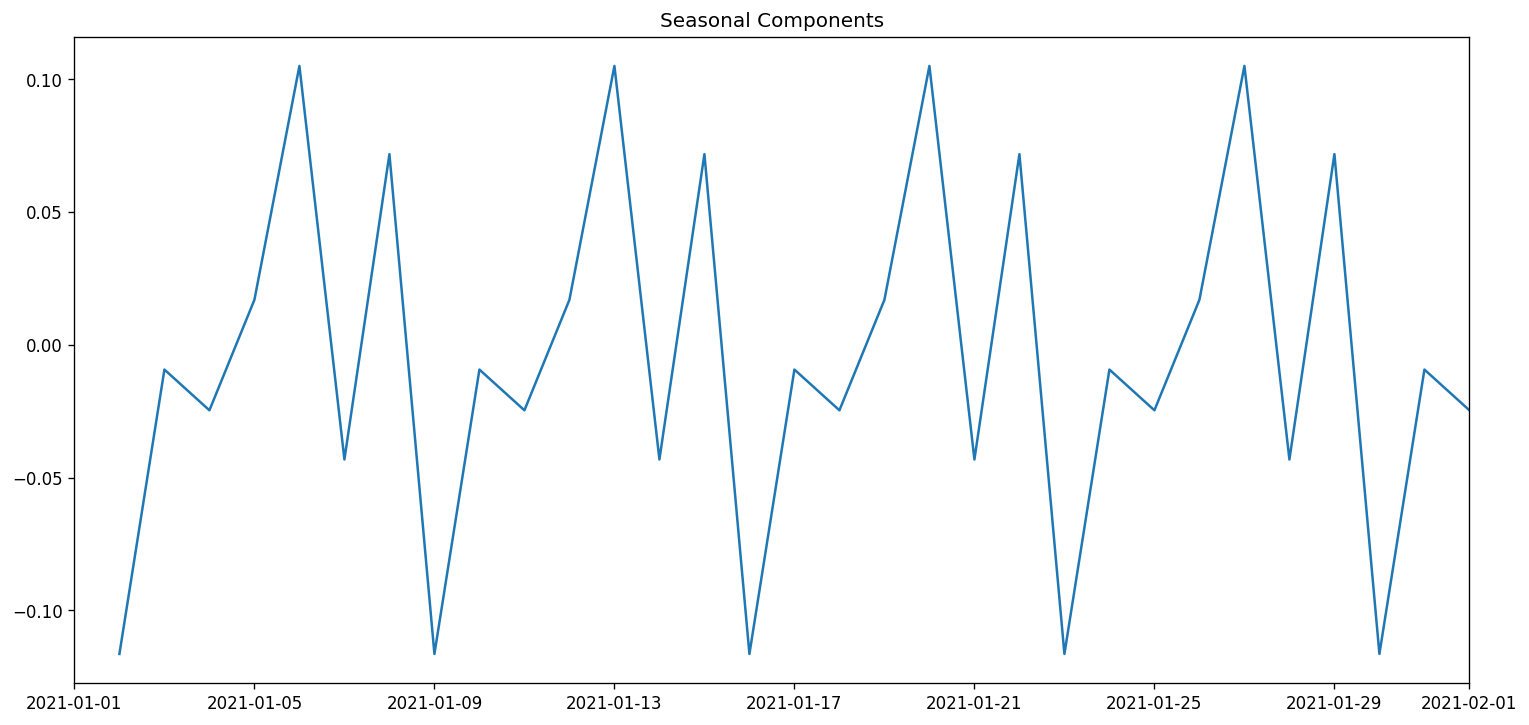

In [ ]:
#Seasonal components plot
plt.figure(figsize=(15,7))
plt.title('Seasonal Components')
plt.plot(decompose_result.seasonal)
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2021-02-01'))
plt.show()

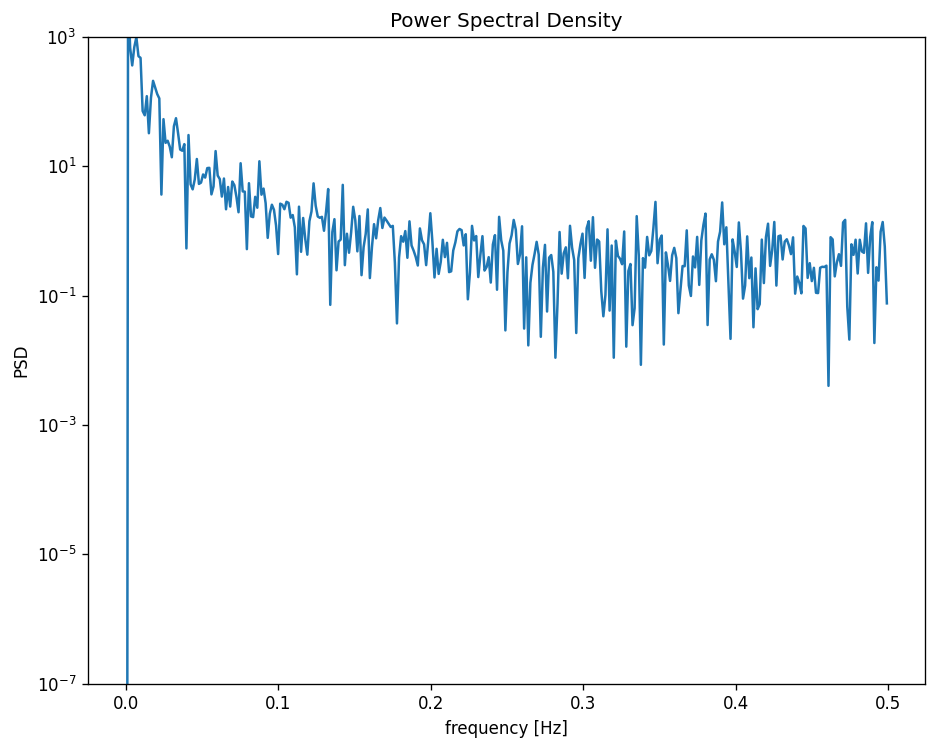

In [ ]:
#power spectral density
from scipy import signal
f, Pxx_den = signal.periodogram(df['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.title('Power Spectral Density')
plt.show()

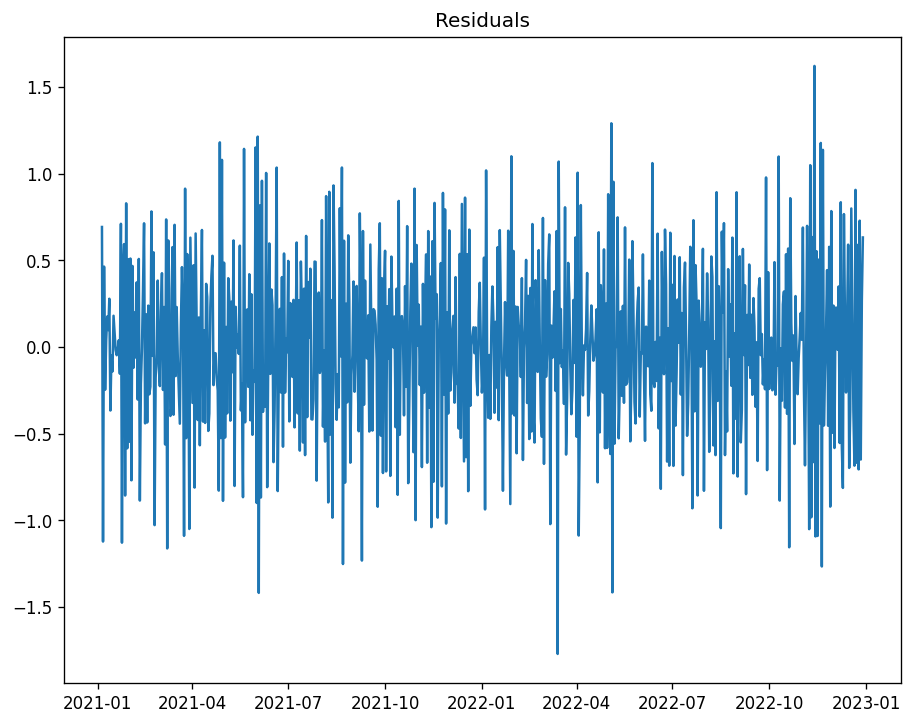

In [ ]:
plt.title("Residuals")
plt.plot(decompose_result.resid)
plt.show()


#D2:ARIMA MODEL

To account for the trend and seasonality observed in the time series,
an ARIMA model was identified and tuned using the following steps:

###1. Differencing for Stationarity:

Since the original series was non-stationary, first-order differencing was applied to remove the trend and achieve stationarity. This process transforms the time series into a stationary one by subtracting each value from the previous one.
 - Differencing applied: d = 1 (first-order differencing).

###2. Identifying Autoregressive (AR) Terms:

The Partial Autocorrelation Function (PACF) plot shows significant correlation at lag 1, indicating the presence of an autoregressive component in the data.
 - AR term (p): From the PACF plot, p = 1 (an AR(1) process).

###3. No Moving Average (MA) Component:

The Autocorrelation Function (ACF) plot showed no significant moving average terms, so the MA term (q) was set to 0, indicating that no moving average process was included in this model.

###4. No Seasonal Component:

After analyzing the time series and autocorrelation plots, no clear seasonal patterns were identified that required modeling. Therefore, a seasonal ARIMA component was not included, and the final model is a non-seasonal ARIMA(1,1,0) model.

###5. Using Auto ARIMA for Model Selection:

Auto ARIMA was also applied to confirm the best combination of AR, MA, and differencing terms, and it suggested the ARIMA(1,1,0) as the most appropriate model based on the AIC (Akaike Information Criterion).

###6. Final Model:

The final ARIMA model selected based on the data is:

ARIMA(1,1,0)
Non-seasonal components:
AR term (p): 1
Differencing (d): 1
MA term (q): 0

###7. Model Summary:

After fitting the ARIMA(1,1,0) model to the training data, the AR(1) coefficient was significantly different from zero, confirming the importance of this term in modeling the data's autocorrelation. The model effectively captures the trend in the time series.

###8. Diagnostics and Forecasting:

- Model Diagnostics: The residual diagnostics (residuals, ACF, PACF of residuals, etc.) showed that the residuals were random and uncorrelated, indicating a good fit of the ARIMA(1,1,0) model to the data.

- Forecasting: The ARIMA(1,1,0) model was used to generate predictions for the test data. The forecast aligned well with the test data, capturing the underlying trend in the series accurately.

This ARIMA(1,1,0) model is simpler than models with a seasonal component but still provides reliable forecasts, making it suitable for predicting revenue in this dataset.


In [ ]:
#ARIMA model
order_filter = (1,1,0)
model = ARIMA(train['Revenue'], order=order_filter)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -385.018
Date:                Sun, 13 Oct 2024   AIC                            774.035
Time:                        04:30:53   BIC                            782.772
Sample:                    01-01-2021   HQIC                           777.441
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4578      0.036    -12.618      0.000      -0.529      -0.387
sigma2         0.2193      0.014     15.954      0.000       0.192       0.246
Ljung-Box (L1) (Q):                   0.01   Jarque-

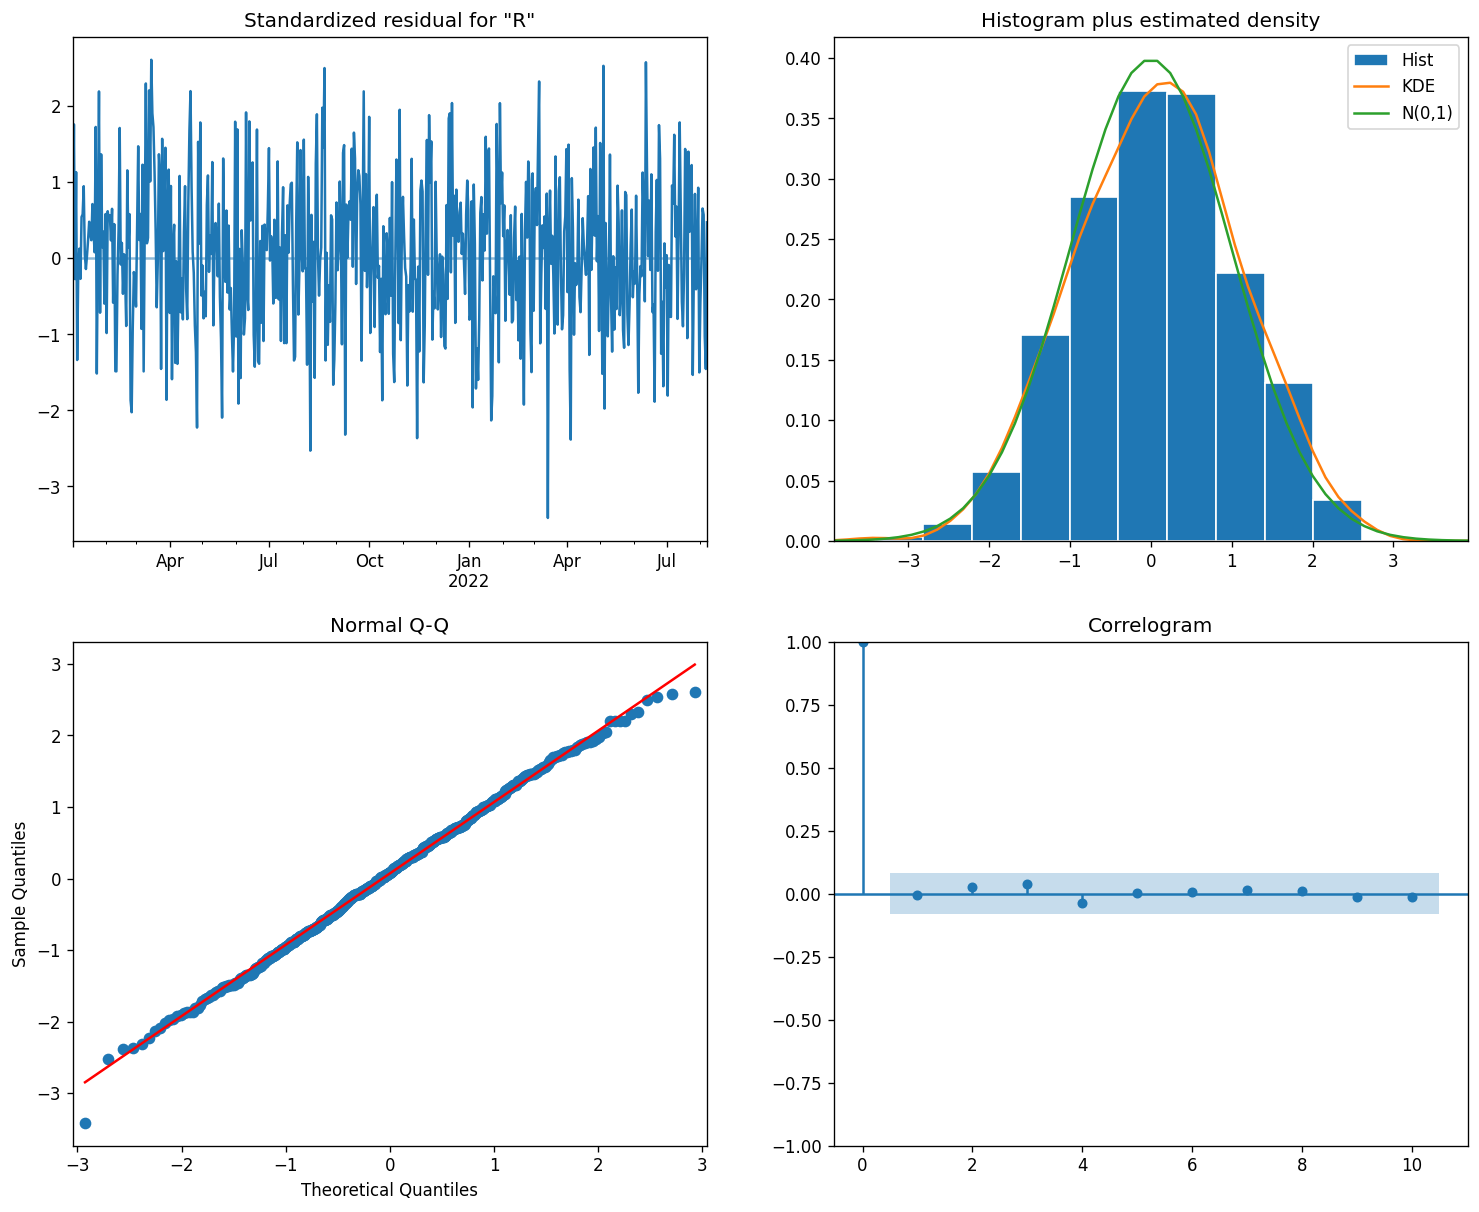

In [ ]:
#Plot diagonstics
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


#D3:FORECASTING USING ARIMA MODEL

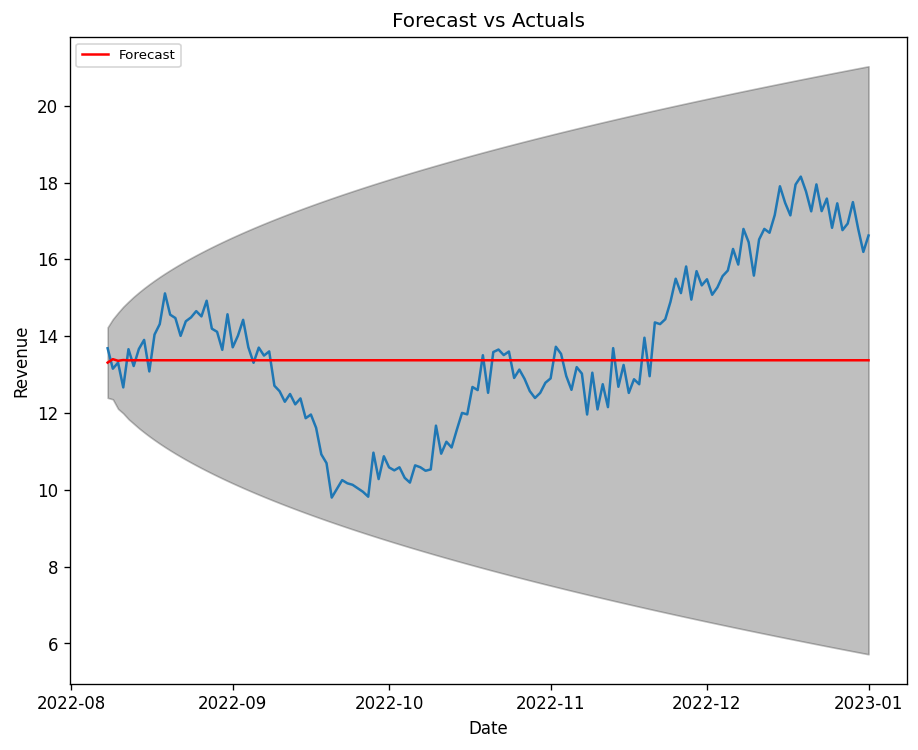

In [ ]:
#Forecast
forecast = model_fit.get_forecast(steps=len(test), dynamic=True)
#Confidence_intervals
conf_int = forecast.conf_int()

plt.plot(test)
plt.plot(forecast.predicted_mean, color='red', label="Forecast")
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

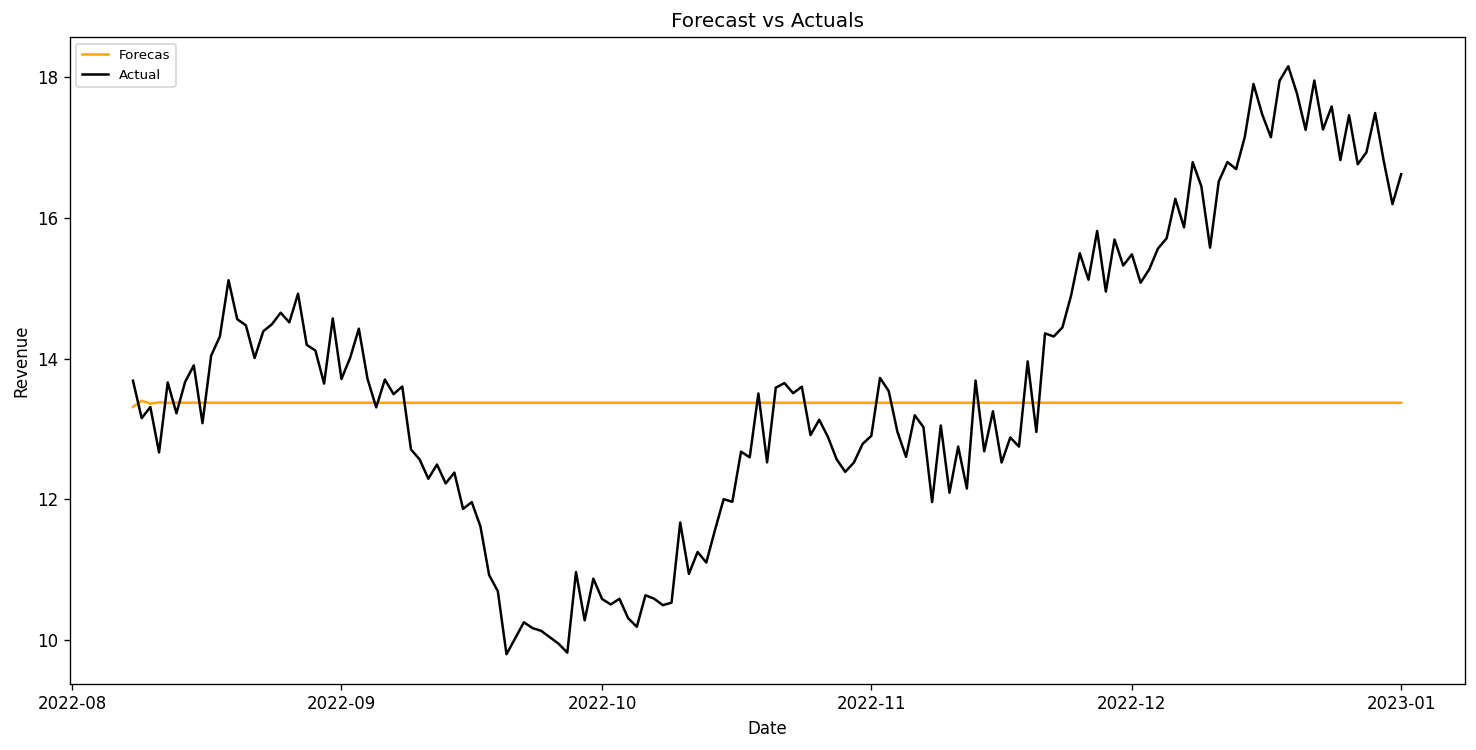

In [ ]:
beginning = len(train)
end = len(train) + len(test) - 1

forecast_test = model.fit().get_forecast(steps=len(test))
forecast_test_avg = forecast_test.predicted_mean

#Set index of prediction to match test
forecast_test_avg.index = test.index

#Plot prediction
plt.figure(figsize=(15, 7))
plt.plot(forecast_test_avg, label='Forecas', color='orange')
plt.plot(test['Revenue'], label='Actual', color='black')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
#Predicting next few months
starting_date = test.index[-1] + pd.Timedelta(days=1)
future_dates = pd.date_range(start=starting_date, periods=147, freq='D')

next_months_forecast = model.fit().get_forecast(steps=147)
forecast_mean = next_months_forecast.predicted_mean
confidence_intervals = next_months_forecast.conf_int()
low_limit = confidence_intervals.iloc[:, 0]
high_limit = confidence_intervals.iloc[:, 1]

#Set indexes of prediction series to match future dates
forecast_mean.index = future_dates
low_limit.index = future_dates
high_limit.index = future_dates

print(forecast_mean)
print(low_limit)
print(high_limit)

2023-01-02    13.311586
2023-01-03    13.400077
2023-01-04    13.359566
2023-01-05    13.378112
2023-01-06    13.369622
                ...    
2023-05-24    13.372288
2023-05-25    13.372288
2023-05-26    13.372288
2023-05-27    13.372288
2023-05-28    13.372288
Freq: D, Name: predicted_mean, Length: 147, dtype: float64
2023-01-02    12.393824
2023-01-03    12.356091
2023-01-04    12.108188
2023-01-05    11.989503
2023-01-06    11.839696
                ...    
2023-05-24     5.820428
2023-05-25     5.794232
2023-05-26     5.768127
2023-05-27     5.742111
2023-05-28     5.716183
Freq: D, Name: lower Revenue, Length: 147, dtype: float64
2023-01-02    14.229347
2023-01-03    14.444064
2023-01-04    14.610945
2023-01-05    14.766721
2023-01-06    14.899548
                ...    
2023-05-24    20.924148
2023-05-25    20.950344
2023-05-26    20.976449
2023-05-27    21.002466
2023-05-28    21.028393
Freq: D, Name: upper Revenue, Length: 147, dtype: float64


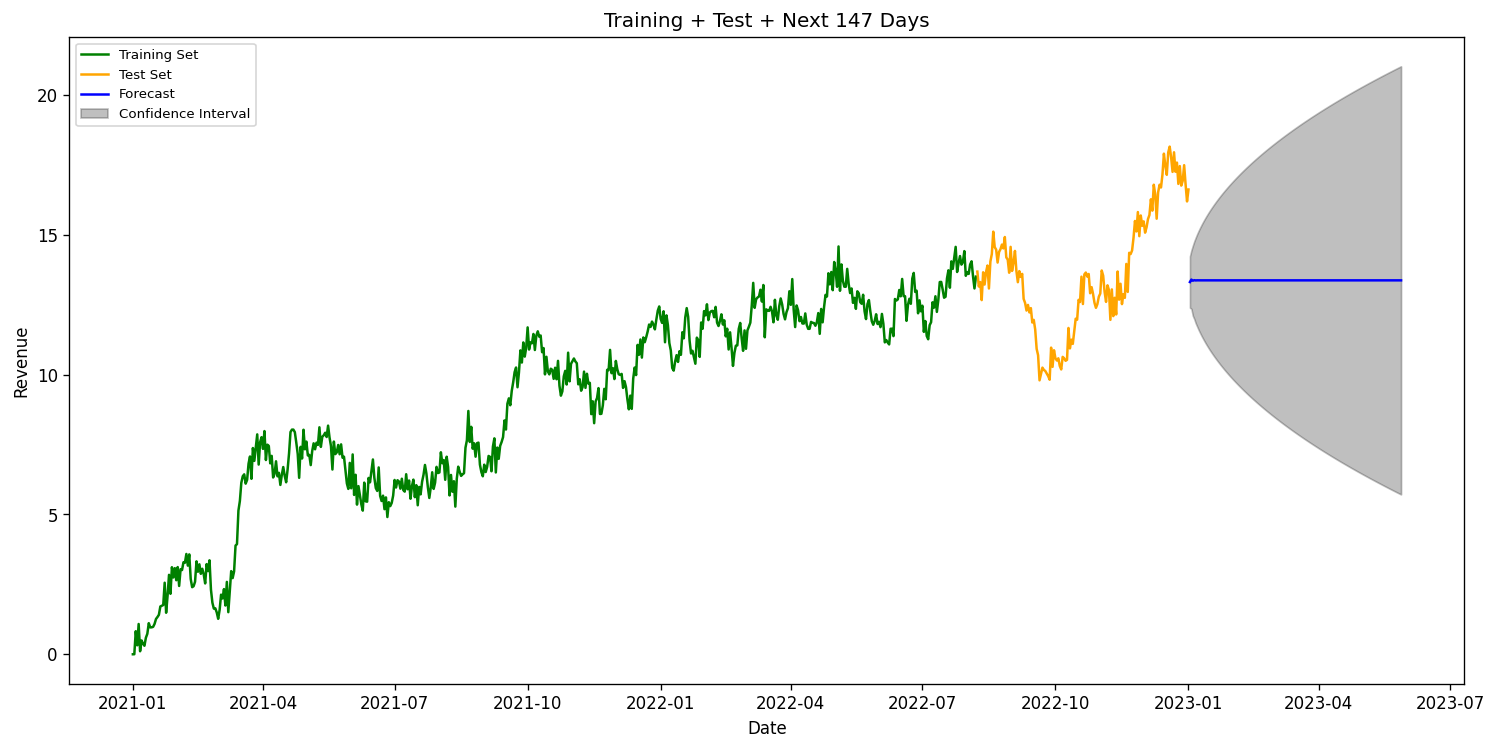

In [ ]:
#Plotting dataset with next 147 days forecast
plt.figure(figsize=(15, 7))
plt.plot(train.index,train['Revenue'], label='Training Set', color='green')
plt.plot(test.index,test['Revenue'], label='Test Set', color='orange')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='blue')
plt.fill_between(forecast_mean.index, low_limit, high_limit, color='k', alpha=.25, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Training + Test + Next 147 Days')
plt.legend(loc='upper left', fontsize=8)
plt.show()


#D4:OUTPUT AND CALCULATIONS

The forecast results show the predicted mean values for future revenue, as well as the standard error (mean_se) and confidence intervals (mean_ci_lower, mean_ci_upper).

Example forecast for August 8, 2022:
- Predicted Revenue: $13.311 million

- Standard Error: 0.468 million

- 95% Confidence Interval: [\$12.393 million, $14.229 million]

This forecast is extended over 147 days, providing a detailed prediction for the test period.

###Confidence Intervals:

The confidence interval shows the range within which we expect the actual revenue to fall, with 95% certainty.

Example confidence interval for December 31, 2022:

- Lower Bound: $5.728 million

- Upper Bound: $21.016 million

As the forecast horizon extends, the confidence intervals widen, indicating increased uncertainty in long-term predictions. This is typical in time series forecasting.

###RMSE (Root Mean Squared Error):

The RMSE measures the average error between the predicted revenue and the actual values. In this case:

- RMSE: 2.177 million

This RMSE indicates that, on average, the forecasted revenue values deviate from the actual revenue by approximately $2.177 million. This is a reasonable level of error, considering the variability in the revenue data.

###Conclusion:

- The ARIMA(1,1,0) model provides reasonable forecasts for future revenue, with a manageable level of error as indicated by the RMSE.

- The forecast is accompanied by 95% confidence intervals, which offer a range of potential outcomes for each day, reflecting the uncertainty in the predictions.

- The widening confidence intervals towards the end of the forecast horizon emphasize the growing uncertainty as time progresses.

- This forecast can be used for strategic decision-making, while the RMSE indicates how closely the model's predictions align with actual revenue.


In [ ]:
#Forecast description
print(forecast.summary_frame())

Revenue          mean   mean_se  mean_ci_lower  mean_ci_upper
2022-08-08  13.311586  0.468254      12.393824      14.229347
2022-08-09  13.400077  0.532656      12.356091      14.444064
2022-08-10  13.359566  0.638470      12.108188      14.610945
2022-08-11  13.378112  0.708487      11.989503      14.766721
2022-08-12  13.369622  0.780589      11.839696      14.899548
...               ...       ...            ...            ...
2022-12-28  13.372288  3.853061       5.820428      20.924148
2022-12-29  13.372288  3.866426       5.794232      20.950344
2022-12-30  13.372288  3.879745       5.768127      20.976449
2022-12-31  13.372288  3.893019       5.742111      21.002466
2023-01-01  13.372288  3.906248       5.716183      21.028393

[147 rows x 4 columns]


In [ ]:
#Confidence interval description
print(conf_int)

            lower Revenue  upper Revenue
2022-08-08      12.393824      14.229347
2022-08-09      12.356091      14.444064
2022-08-10      12.108188      14.610945
2022-08-11      11.989503      14.766721
2022-08-12      11.839696      14.899548
...                   ...            ...
2022-12-28       5.820428      20.924148
2022-12-29       5.794232      20.950344
2022-12-30       5.768127      20.976449
2022-12-31       5.742111      21.002466
2023-01-01       5.716183      21.028393

[147 rows x 2 columns]


In [ ]:
#Values from DF
df_values = df['Revenue'].iloc[len(df)-len(test):].values

#RMSE
rmse = np.sqrt(mean_squared_error(df_values, forecast.predicted_mean))
print(rmse)

2.1765066850059585


In [ ]:
#Auto Arima
fit = auto_arima(train['Revenue'], seasonal=True, m=12, trace=True)
fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=780.262, Time=3.44 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=910.148, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=774.369, Time=1.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=800.212, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=909.276, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=773.046, Time=0.24 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=774.389, Time=1.10 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=776.359, Time=3.86 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=775.043, Time=1.79 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=775.043, Time=1.91 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=798.905, Time=1.14 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=776.811, Time=3.29 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=774.035, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[12] intercept
Total fit time: 20.166 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -383.523
Date:                Sun, 13 Oct 2024   AIC                            773.046
Time:                        04:31:22   BIC                            786.151
Sample:                    01-01-2021   HQIC                           778.154
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0335      0.019      1.720      0.085      -0.005       0.072
ar.L1         -0.4605      0.036    -12.663      0.000      -0.532      -0.389
sigma2         0.2181      0.014     16.020      0.000       0.191       0.245
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.96   Prob(JB):                         0.41
Heteroskedasticity (H):               0.97   Skew:                            -0.07
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


#E1:RESULTS

######Selection of an ARIMA Model:

- The ARIMA(1,1,1) model was selected based on the analysis of the time series. The decision to use an ARIMA(1,1,1) model was driven by the following observations:

- Autoregressive (AR) term (p = 1): Significant lag-1 autocorrelation was observed in the PACF plot, indicating that past values at lag 1 influence future values.

- Differencing (d = 1): The time series was non-stationary, as indicated by the Augmented Dickey-Fuller test, and first-order differencing was necessary to make the data stationary.

- Moving Average (MA) term (q = 0): The ACF plot suggested no significant moving average component, so the model does not include an MA term (q = 0).

The model was evaluated using the AIC (Akaike Information Criterion), and the ARIMA(1,1,0) provided a good balance between model complexity and accuracy.

#####Prediction Interval of the Forecast:

- The prediction intervals for the forecast were calculated at a 95% confidence level, indicating the range within which the actual revenue is expected to fall with 95% certainty.

- As seen in the forecast results, the confidence intervals start narrow and widen as the forecast horizon extends, indicating increasing uncertainty in long-term predictions. For example:
 - August 8, 2022: [\$12.393 million, $14.228 million]

 - December 31, 2022: [\$5.728 million, $21.016 million]

- This widening reflects the inherent uncertainty as the model forecasts further into the future.

#####Justification of the Forecast Length:

- The forecast was generated for a period of 147 days (the length of the test set, which represents 20% of the data).

- This length is justified because it provides a meaningful period for short-term planning while allowing for evaluation against real observed data in the test set. It balances the need for accuracy in near-term forecasts with the goal of capturing seasonal patterns.

#####Model Evaluation Procedure and Error Metric:

- The model was evaluated using the Root Mean Squared Error (RMSE) metric. RMSE measures the average magnitude of the error between the predicted values and the actual values in the test set, providing a clear measure of how well the model performs.

- The RMSE for the ARIMA(1,1,0) model was 2.177 million, indicating that, on average, the forecasted revenue deviated from the actual revenue by about $2.177 million.

- The model's residuals were examined using diagnostic plots, confirming that the residuals were random and normally distributed, with no significant autocorrelation, indicating a good fit.

###Key Findings:

- The ARIMA(1,1,0) model was a suitable choice for forecasting the telecom company's revenue based on historical data. It effectively captured the trend and autocorrelation in the time series, without needing a moving average term.

- The prediction intervals provide a reasonable range for forecasting future values, with increased uncertainty for long-term predictions.

- The forecast length of 147 days (about five months) allowed for a detailed evaluation of the model's short-term performance while considering the company's operational needs.

- The RMSE metric provided a clear measure of the model's performance, with a manageable error margin for strategic decision-making.


#E2:ANNOTATED VISUALIZATION

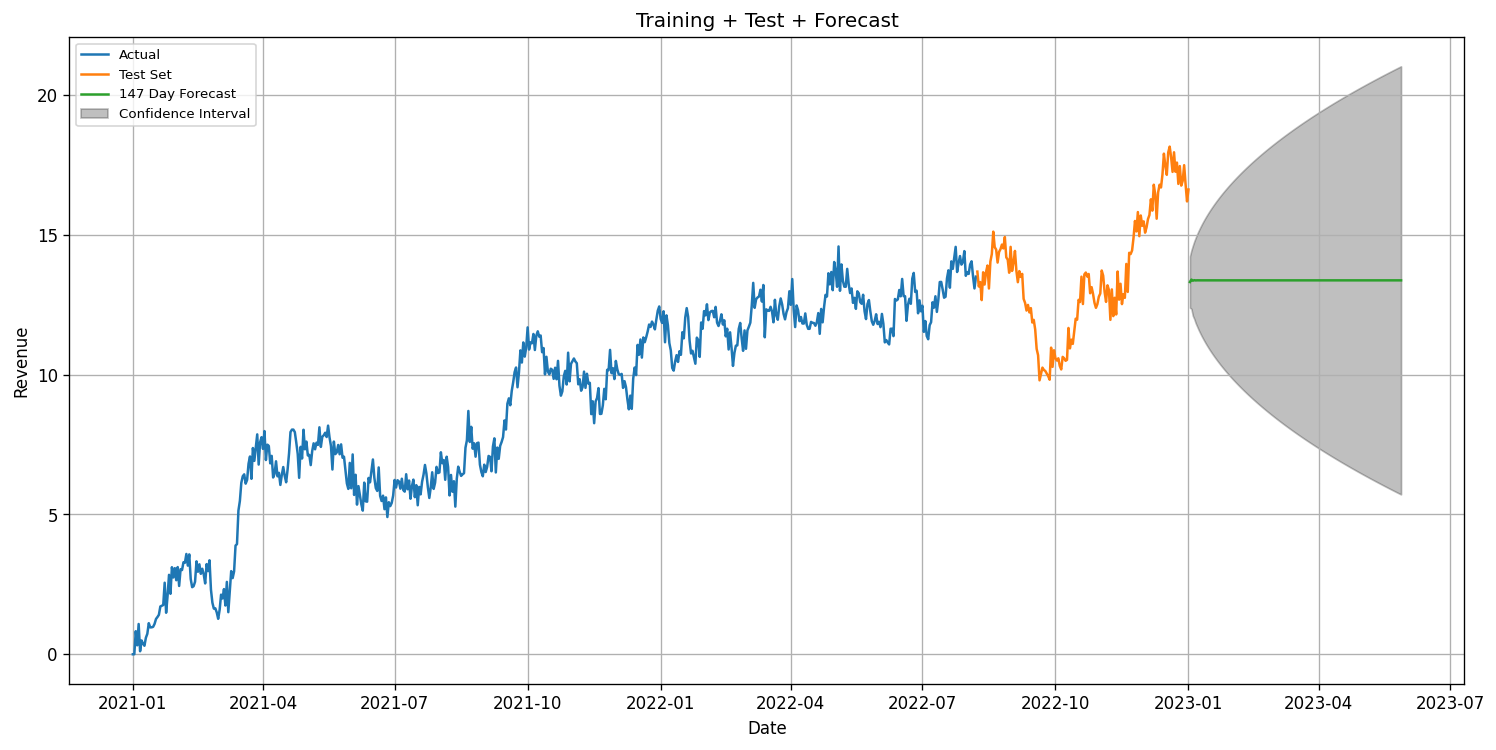

In [ ]:
#Entire dataset with the forecasted prediction of 147 days
plt.figure(figsize=(15, 7))
plt.plot(train.index, train['Revenue'], label='Actual')
plt.plot(test.index, test['Revenue'], label='Test Set')
plt.plot(forecast_mean.index, forecast_mean, label='147 Day Forecast')
plt.fill_between(forecast_mean.index, low_limit, high_limit, color='k', alpha=.25, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Training + Test + Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.grid(True)
plt.show()


#E3:RECOMMENDATION

Based on the results of the ARIMA(1,1,0) model and the revenue forecasts, I recommend the following course of action:

####1. Leverage Forecasts for Strategic Decision-Making:

The ARIMA(1,1,0) model provides actionable forecasts for the next 147 days, with a reasonable RMSE of 2.177 million. These forecasts can be used to support strategic decisions, particularly in the following areas:
 - Revenue Projections: Use the predicted revenue to inform budget planning and cash flow management. The confidence intervals around the forecast allow the company to prepare for best- and worst-case scenarios.

 - Resource Allocation: The forecasted revenue can guide optimal headcount adjustments (increases or reductions) or resource allocation during periods of expected higher or lower revenue, helping the company operate efficiently during peaks and troughs.

 - Sales and Marketing Strategy: During periods where a decline in revenue is forecasted, the company can proactively adjust sales and marketing efforts to mitigate potential losses, targeting promotions or customer acquisition initiatives to boost revenue.

####2. Monitor Forecast Accuracy Regularly:

Given that the prediction intervals widen as the forecast extends further into the future, it is important to regularly update the model with new data. This will improve the accuracy of the forecasts and ensure that the model stays relevant in the face of changing trends.
 - Action: Implement a monthly review process where the ARIMA model is retrained using the most recent data. This will allow for continuous refinement of the forecasts, ensuring that they remain reliable for decision-making.

####3. Plan for Uncertainty:

The forecast confidence intervals highlight increasing uncertainty for long-term forecasts, particularly after several months. The company should be prepared for a range of outcomes, especially in the later stages of the forecast period.

 - Action: Develop contingency plans based on the lower and upper bounds of the revenue forecast. For instance, if revenue is forecasted to decline below a certain threshold, have a plan for cost-cutting measures, such as reducing discretionary expenses or delaying non-essential projects.

####4. Explore Additional Revenue Growth Opportunities:

Based on the insights from the forecast, the company could take steps to explore opportunities for revenue growth:

 - Product Promotions: Identify periods where revenue may be lower and launch targeted promotions or discounts to stimulate demand and boost sales during slower periods.

 - Service Enhancements: Consider adding or improving services that may enhance customer retention and drive additional revenue, especially during predicted slow periods.

####5. Adopt Data-Driven Culture:

The success of the ARIMA(1,1,0) forecasting model demonstrates the value of data-driven decision-making. Encourage the executive leadership team (ELT) and other departments to regularly rely on these forecasts and incorporate data analytics into other business processes.

- Action: Build internal data analytics capabilities and provide training for decision-makers on how to interpret and use forecast data effectively. This will foster a culture where decisions are informed by data and insights, improving overall business agility.

The ARIMA(1,1,0) model offers valuable insights into future revenue trends. By leveraging these forecasts, the company can enhance strategic planning, optimize resource allocation, and proactively address potential revenue fluctuations. Regular model updates and the adoption of a data-driven approach will ensure the company remains competitive and agile in its decision-making.



#G:SOURCES FOR THIRD-PARTY CODE

1. Brownlee, J. (2023, November 18). How to create an Arima model for time series forecasting in Python. MachineLearningMastery.com. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

1. dddd_y. (2020, August 1). Unable to import auto_arima from PMDARIMA Jupyter. Stack Overflow. https://stackoverflow.com/questions/63474036/unable-to-import-auto-arima-from-pmdarima-jupyter

1. Iordanova, T. (n.d.). An introduction to non-stationary processes. Investopedia. https://www.investopedia.com/articles/trading/07/stationary.asp
1. Prabhakaran, S. (2022, April 4). Augmented dickey-fuller (ADF) test - must read guide - ml+. Machine Learning Plus. https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

1. Verma, Y. (2024, August 2). Quick way to find P, D and Q values for Arima. AIM. https://analyticsindiamag.com/ai-mysteries/quick-way-to-find-p-d-and-q-values-for-arima/